In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# Standard python libraries
import os
import requests

# Essential DS libraries
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch

# LightAutoML presets, task and report generation
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task
from lightautoml.report.report_deco import ReportDeco


pd.set_option('display.max_columns', None)

In [14]:
appl_train = pd.read_csv("application_train.csv")
bureau = pd.read_csv("bureau.csv")
prev_appl = pd.read_csv("previous_application.csv")

In [15]:
appl_train

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.0220,0.0198,0.0,0.0000,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.0000,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.0790,0.0554,0.0,0.0000,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.0100,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

Из всех полей заявки следует убрать следующие:

1.	Не актуальны российскому рынку
2.	Невозможно достать путём опроса
3.	Кодированы
4.	Не интерпретируемы

In [53]:
columns_to_drop = [
 #'SK_ID_CURR',
 #'TARGET',
 'NAME_CONTRACT_TYPE', # возобновляемость кредита, не применимо для ипотеки в России. 
 #'CODE_GENDER',
 #'FLAG_OWN_CAR',
 #'FLAG_OWN_REALTY',
 #'CNT_CHILDREN',
 #'AMT_INCOME_TOTAL',
 #'AMT_CREDIT',
 # 'AMT_ANNUITY',  # размер аннуиттентного платежа. Позволит вычислить срок кредита
 'AMT_GOODS_PRICE', # цена товара, характеристика потребительского кредита. Удалим чуть позже, когда убедимся в том, что в фильтрованной выборке нет товаров
 #'NAME_TYPE_SUITE',
 #'NAME_INCOME_TYPE',
 #'NAME_EDUCATION_TYPE',
 #'NAME_FAMILY_STATUS',
 #'NAME_HOUSING_TYPE',
 'REGION_POPULATION_RELATIVE', #относительная популярность зарубежного региона без специфики
 #'DAYS_BIRTH',
 #'DAYS_EMPLOYED',
 #'DAYS_REGISTRATION',
 #'DAYS_ID_PUBLISH',
 #'OWN_CAR_AGE',
 #'FLAG_MOBIL',
 #'FLAG_EMP_PHONE',
 #'FLAG_WORK_PHONE',
 #'FLAG_CONT_MOBILE',
 #'FLAG_PHONE',
 #'FLAG_EMAIL',
 #'OCCUPATION_TYPE',
 #'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT', # рейтинг региона из соревнования, интересен, но не важен в терминах задачи
 'REGION_RATING_CLIENT_W_CITY', # рейтинг города из соревнования, интересен, но не важен в терминах задачи
 #'WEEKDAY_APPR_PROCESS_START',
 #'HOUR_APPR_PROCESS_START',
 #'REG_REGION_NOT_LIVE_REGION',
 #'REG_REGION_NOT_WORK_REGION',
 #'LIVE_REGION_NOT_WORK_REGION',
 #'REG_CITY_NOT_LIVE_CITY',
 #'REG_CITY_NOT_WORK_CITY',
 #'LIVE_CITY_NOT_WORK_CITY',
 #'ORGANIZATION_TYPE',
 #'EXT_SOURCE_1', # кодированные колонки, предположительно скоринг
 #'EXT_SOURCE_2', # кодированные колонки, предположительно скоринг
 #'EXT_SOURCE_3', # кодированные колонки, предположительно скоринг
    # блок данных про недвижимость клиента. Может быть модифицирован после первых итераций построения модели
 #'APARTMENTS_AVG',
 #'BASEMENTAREA_AVG',
 #'YEARS_BEGINEXPLUATATION_AVG',
 #'YEARS_BUILD_AVG',
 #'COMMONAREA_AVG',
 #'ELEVATORS_AVG',
 #'ENTRANCES_AVG',
 #'FLOORSMAX_AVG',
 #'FLOORSMIN_AVG',
 #'LANDAREA_AVG',
 #'LIVINGAPARTMENTS_AVG',
 #'LIVINGAREA_AVG',
 #'NONLIVINGAPARTMENTS_AVG',
 #'NONLIVINGAREA_AVG',
 #'APARTMENTS_MODE',
 #'BASEMENTAREA_MODE',
 #'YEARS_BEGINEXPLUATATION_MODE',
 #'YEARS_BUILD_MODE',
 #'COMMONAREA_MODE',
 #'ELEVATORS_MODE',
 #'ENTRANCES_MODE',
 #'FLOORSMAX_MODE',
 #'FLOORSMIN_MODE',
 #'LANDAREA_MODE',
 #'LIVINGAPARTMENTS_MODE',
 #'LIVINGAREA_MODE',
 #'NONLIVINGAPARTMENTS_MODE',
 #'NONLIVINGAREA_MODE',
 #'APARTMENTS_MEDI',
 #'BASEMENTAREA_MEDI',
 #'YEARS_BEGINEXPLUATATION_MEDI',
 #'YEARS_BUILD_MEDI',
 #'COMMONAREA_MEDI',
 #'ELEVATORS_MEDI',
 #'ENTRANCES_MEDI',
 #'FLOORSMAX_MEDI',
 #'FLOORSMIN_MEDI',
 #'LANDAREA_MEDI',
 #'LIVINGAPARTMENTS_MEDI',
 #'LIVINGAREA_MEDI',
 #'NONLIVINGAPARTMENTS_MEDI',
 #'NONLIVINGAREA_MEDI',
 #'FONDKAPREMONT_MODE',
 #'HOUSETYPE_MODE',
 #'TOTALAREA_MODE',
 #'WALLSMATERIAL_MODE',
 #'EMERGENCYSTATE_MODE',
 'OBS_30_CNT_SOCIAL_CIRCLE', # различные показатели количества дефолтов в окружении клиента
 'DEF_30_CNT_SOCIAL_CIRCLE', # различные показатели количества дефолтов в окружении клиента
 'OBS_60_CNT_SOCIAL_CIRCLE', # различные показатели количества дефолтов в окружении клиента
 'DEF_60_CNT_SOCIAL_CIRCLE', # различные показатели количества дефолтов в окружении клиента
 #'DAYS_LAST_PHONE_CHANGE',
 'FLAG_DOCUMENT_2', # кодированные колонки
 'FLAG_DOCUMENT_3', # кодированные колонки
 'FLAG_DOCUMENT_4', # кодированные колонки
 'FLAG_DOCUMENT_5', # кодированные колонки
 'FLAG_DOCUMENT_6', # кодированные колонки
 'FLAG_DOCUMENT_7', # кодированные колонки
 'FLAG_DOCUMENT_8', # кодированные колонки
 'FLAG_DOCUMENT_9', # кодированные колонки
 'FLAG_DOCUMENT_10', # кодированные колонки
 'FLAG_DOCUMENT_11', # кодированные колонки
 'FLAG_DOCUMENT_12', # кодированные колонки
 'FLAG_DOCUMENT_13', # кодированные колонки
 'FLAG_DOCUMENT_14', # кодированные колонки
 'FLAG_DOCUMENT_15', # кодированные колонки
 'FLAG_DOCUMENT_16', # кодированные колонки
 'FLAG_DOCUMENT_17', # кодированные колонки
 'FLAG_DOCUMENT_18', # кодированные колонки
 'FLAG_DOCUMENT_19', # кодированные колонки
 'FLAG_DOCUMENT_20', # кодированные колонки
 'FLAG_DOCUMENT_21', # кодированные колонки
 #'AMT_REQ_CREDIT_BUREAU_HOUR', # число взаимодействий с кредитным бюро перед подачей заявки.
 #'AMT_REQ_CREDIT_BUREAU_DAY', # число взаимодействий с кредитным бюро перед подачей заявки.
 #'AMT_REQ_CREDIT_BUREAU_WEEK', # число взаимодействий с кредитным бюро перед подачей заявки.
 #'AMT_REQ_CREDIT_BUREAU_MON', # число взаимодействий с кредитным бюро перед подачей заявки.
 #'AMT_REQ_CREDIT_BUREAU_QRT', # число взаимодействий с кредитным бюро перед подачей заявки.
 #'AMT_REQ_CREDIT_BUREAU_YEAR' # число взаимодействий с кредитным бюро перед подачей заявки.
]

In [54]:
data = appl_train.drop(columns=columns_to_drop)

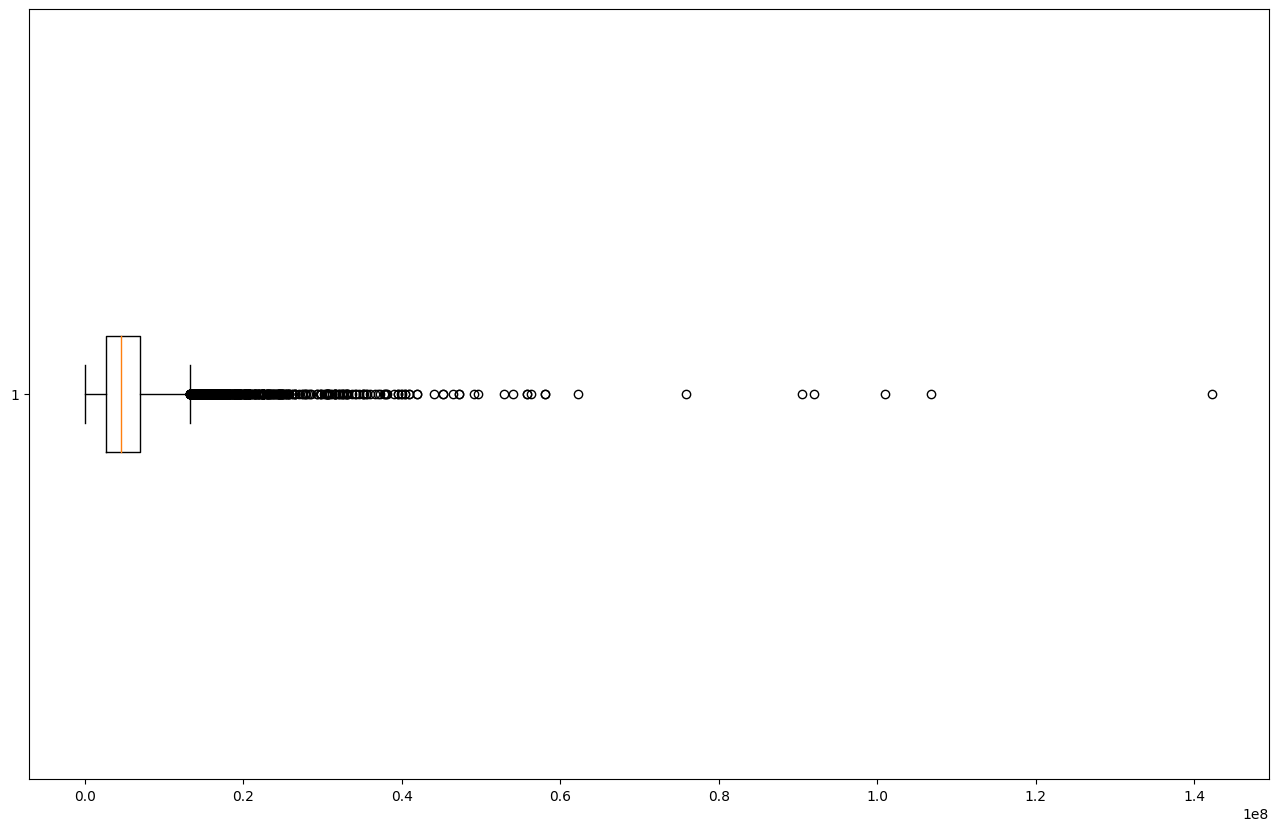

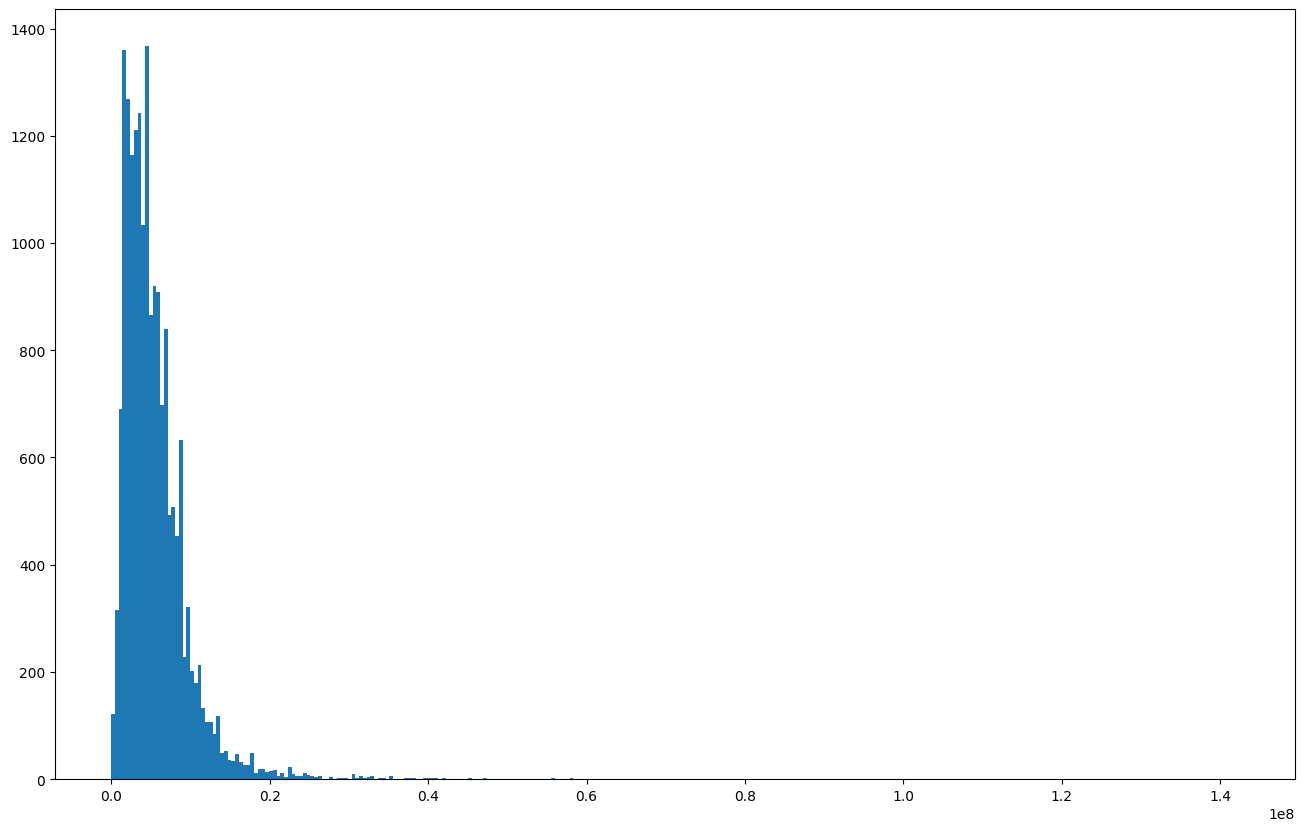

In [18]:
# Сформируем признак ипотечности заявки. Из простых идей - нужно собрать сумму и срок кредита из данных БКИ по ипотекам и 
# экстраполировать их на таблицу заявок

# Сначала посмотрим на распределение суммы кредита

bureau_mortgage = bureau[bureau["CREDIT_TYPE"].isin(['Mortgage','Real estate loan'])]

import matplotlib.pyplot as plt
import seaborn as sns

f1 = plt.figure()
f1.set_size_inches(16, 10)
f2 = plt.figure()
f2.set_size_inches(16, 10)

ax1 = f1.add_subplot(111)
ax1.boxplot(x='AMT_CREDIT_SUM', data=bureau_mortgage, vert=False)

ax2 = f2.add_subplot(111)
ax2.hist(bureau_mortgage['AMT_CREDIT_SUM'], bins=300)
plt.show()    

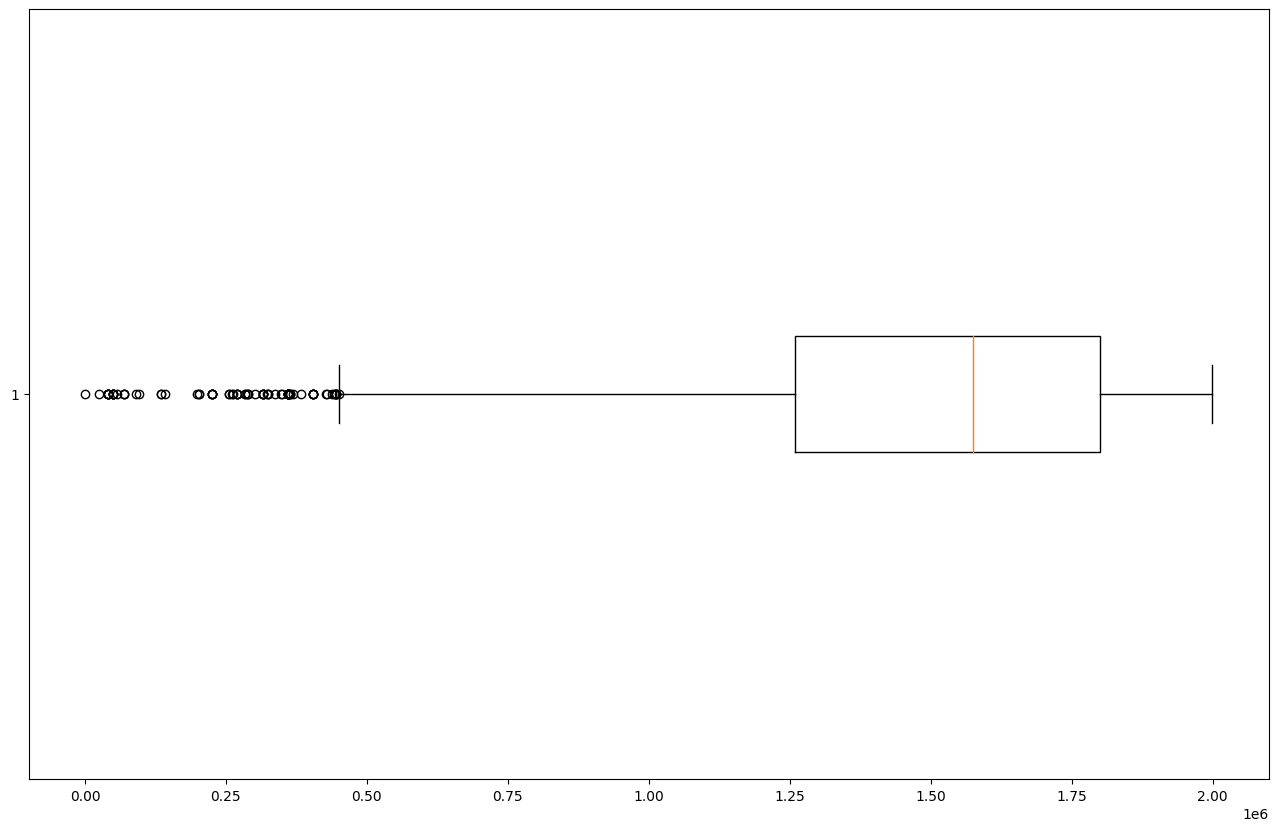

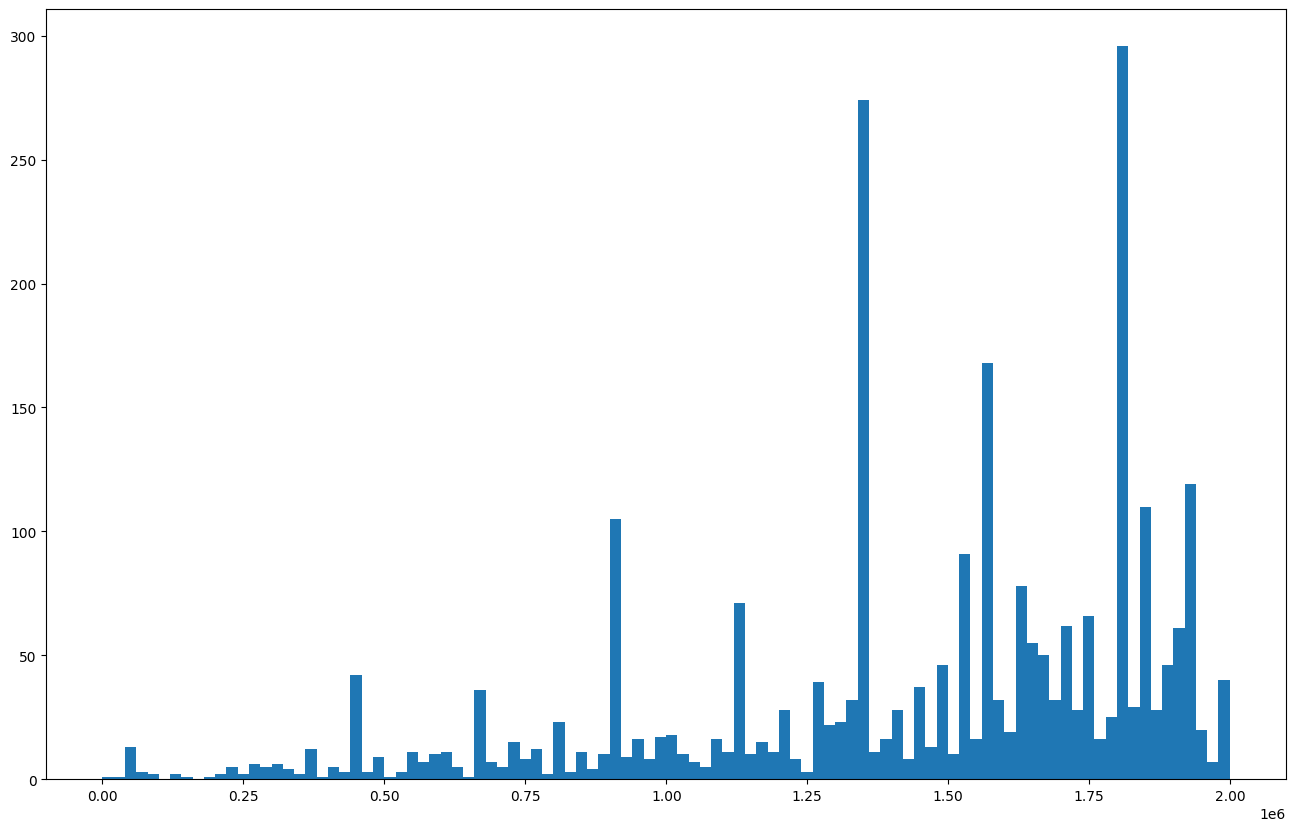

In [19]:
# Очевидно, что подавляющее большинство всех ипотечных кредитов лежит за пределами суммы 0.2e+08, потому следует изучить правую границу распределения. 
# Также, значения за пределами 0.4е+08 следует считать выбросами.

f1 = plt.figure()
f1.set_size_inches(16, 10)
f2 = plt.figure()
f2.set_size_inches(16, 10)

ax1 = f1.add_subplot(111)
ax1.boxplot(x='AMT_CREDIT_SUM', data=bureau_mortgage[bureau_mortgage['AMT_CREDIT_SUM']<0.2e+07], vert=False)

ax2 = f2.add_subplot(111)
ax2.hist(bureau_mortgage[bureau_mortgage['AMT_CREDIT_SUM']<0.2e+07]['AMT_CREDIT_SUM'], bins=100)
plt.show()   

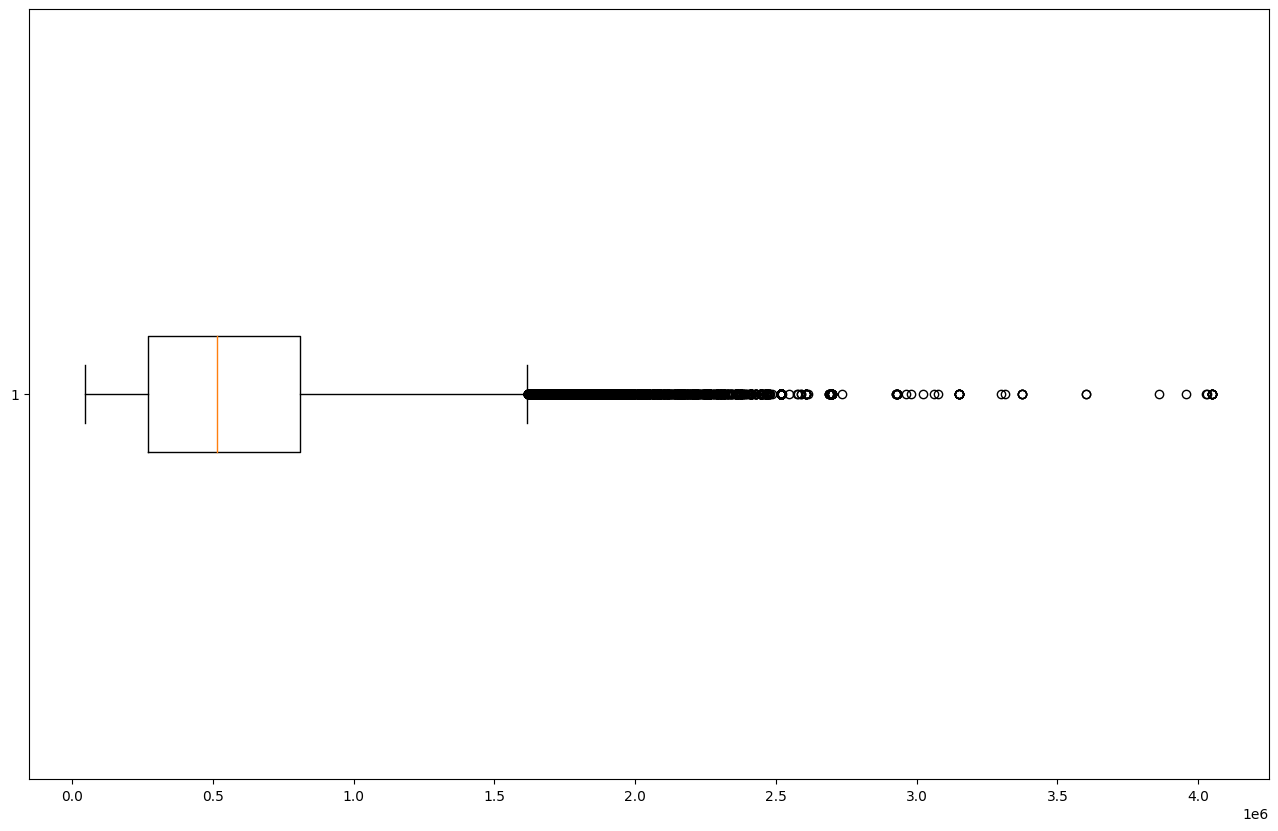

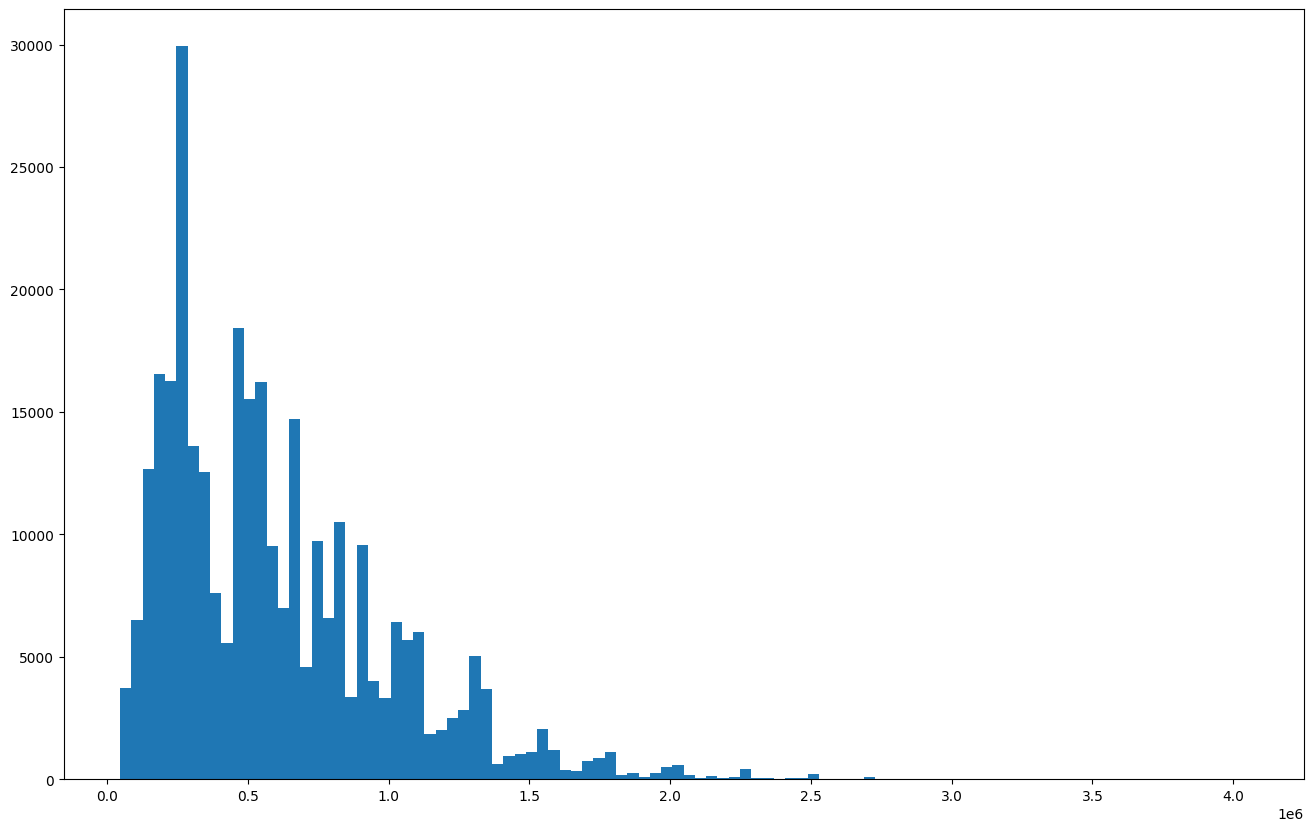

In [20]:
# Таким образом, верхнюю границу 25% перцентиля в распределении кредитов от 2 млн и ниже возьмём 1.25. Получим следующие аналитические границы суммы заявки:
# 1.25e+06<'AMT_CREDIT_SUM'<4e+07
# Наличие верхней аналитической границы стоит проверить при фильтрации заявок по нижней

f1 = plt.figure()
f1.set_size_inches(16, 10)
f2 = plt.figure()
f2.set_size_inches(16, 10)

ax1 = f1.add_subplot(111)
ax1.boxplot(x='AMT_CREDIT', data=data, vert=False)

ax2 = f2.add_subplot(111)
ax2.hist(data['AMT_CREDIT'], bins=100)
plt.show() 

In [21]:
# Из графика видно, что верхняя аналитическая граница не применима и мы можем отфильтровать исходную таблицу по нижней аналитической границе
data_mortgage = data[data["AMT_CREDIT"] >= 1.25e+06]
data_mortgage

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
1,100003,0,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.0790,0.0554,0.0000,0.0000,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.0100,reg oper account,block of flats,0.0714,Block,No,-828.0,0.0,0.0,0.0,0.0,0.0,0.0
6,100009,0,F,Y,Y,1,171000.0,1560726.0,41301.0,1395000.0,Unaccompanied,Commercial associate,Higher education,Married,House / apartment,-13778,-3130,-1213.0,-619,17.0,1,1,0,1,1,0,Accountants,3.0,SUNDAY,16,0,0,0,0,0,0,Business Entity Type 3,0.774761,0.724000,0.492060,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1562.0,0.0,0.0,0.0,1.0,1.0,2.0
7,100010,0,M,Y,Y,0,360000.0,1530000.0,42075.0,1530000.0,Unaccompanied,State servant,Higher education,Married,House / apartment,-18850,-449,-4597.0,-2379,8.0,1,1,1,1,0,0,Managers,2.0,MONDAY,16,0,0,0,0,1,1,Other,NaN,0.714279,0.540654,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1070.0,0.0,0.0,0.0,0.0,0.0,0.0
48,100055,0,F,N,N,0,130500.0,1350000.0,37255.5,1350000.0,Unaccompanied,State servant,Secondary / secondary special,Married,House / apartment,-19727,-4411,-6225.0,-3199,NaN,1,1,1,1,1,0,Managers,2.0,THURSDAY,10,0,0,0,0,0,0,Government,0.710427,0.589187,0.466864,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-784.0,0.0,0.0,0.0,0.0,0.0,0.0
49,100056,0,M,Y,Y,0,360000.0,1506816.0,49927.5,1350000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,-18264,-9523,-5504.0,-1797,3.0,1,1,0,1,0,0,Laborers,2.0,THURSDAY,10,0,0,0,0,1,1,Transport: type 2,NaN,0.523934,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

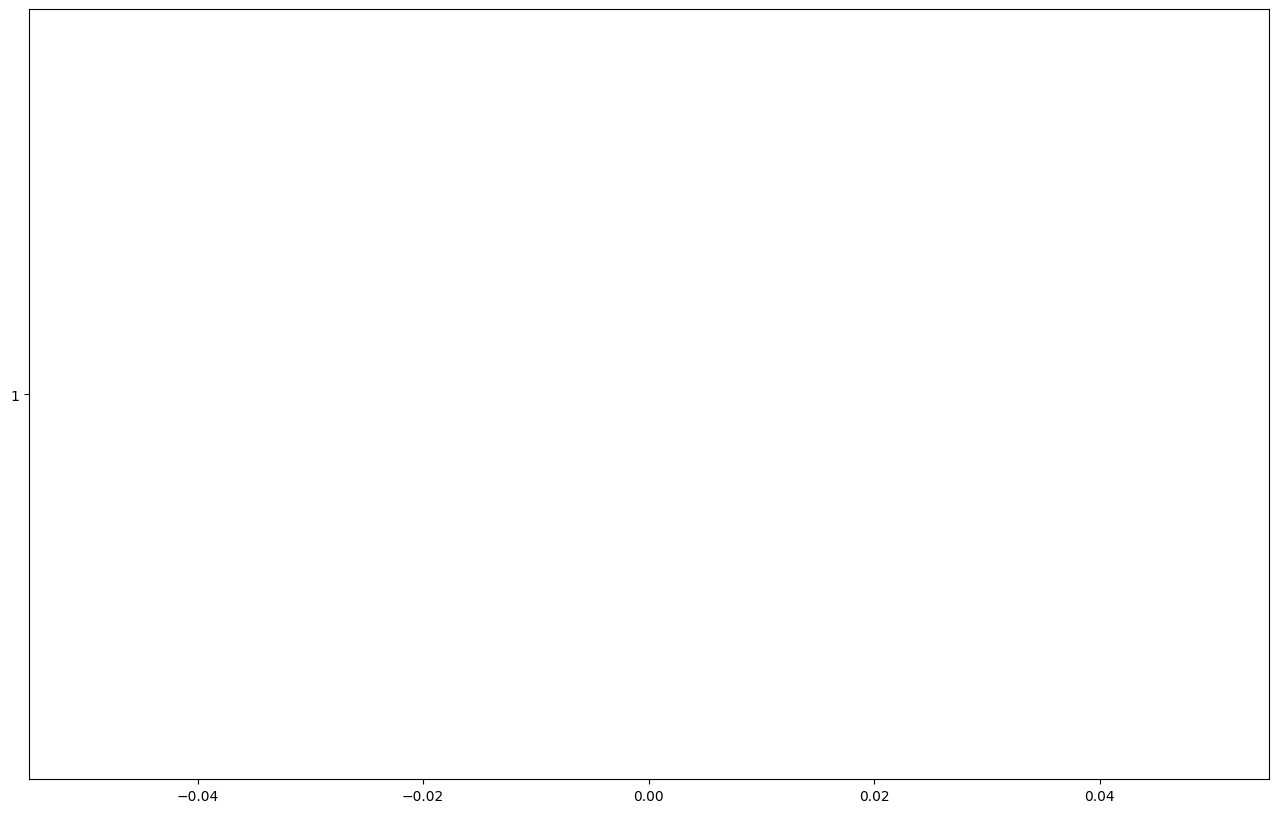

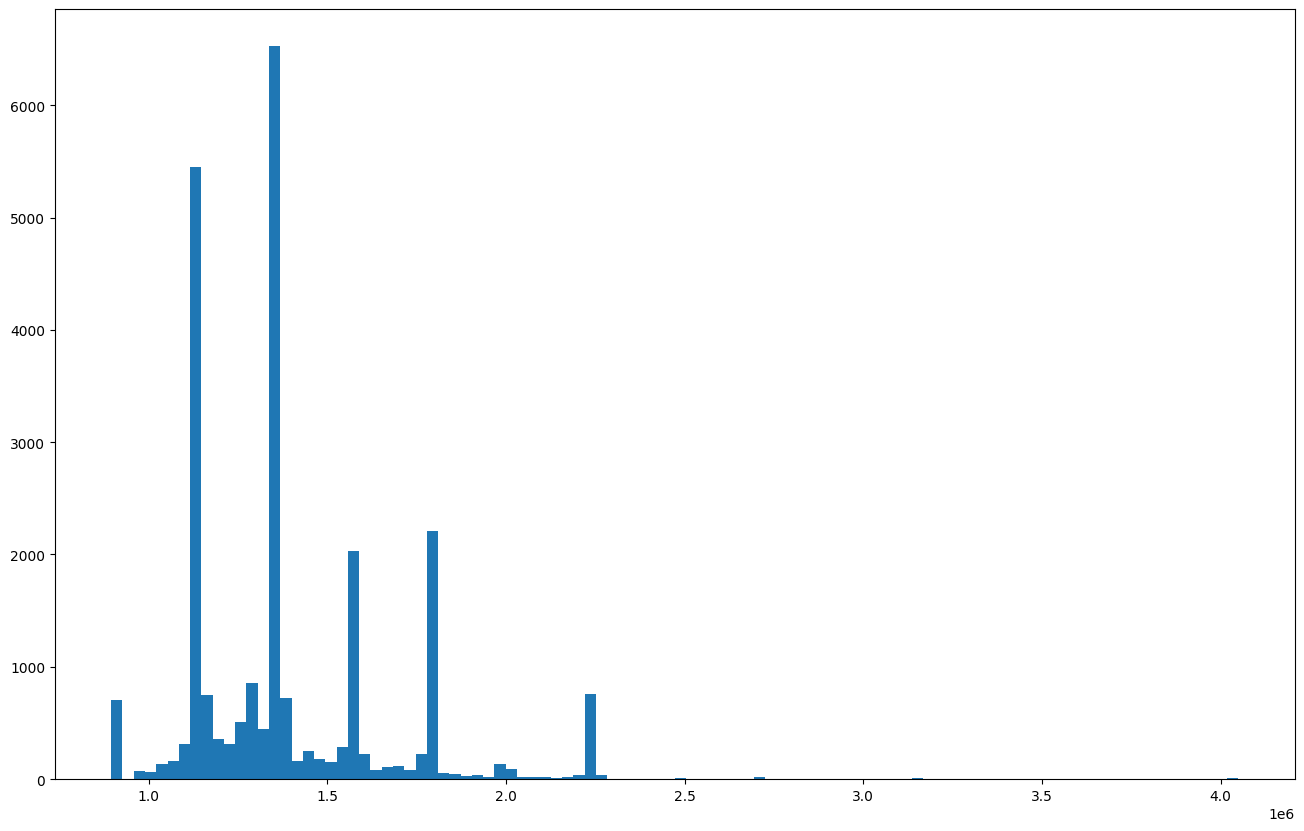

In [29]:
f1 = plt.figure()
f1.set_size_inches(16, 10)
f2 = plt.figure()
f2.set_size_inches(16, 10)

ax1 = f1.add_subplot(111)
ax1.boxplot(x='AMT_GOODS_PRICE', data=data_mortgage, vert=False)

ax2 = f2.add_subplot(111)
ax2.hist(data_mortgage['AMT_GOODS_PRICE'], bins=100)
plt.show() 

Анализ поля AMT_GOODS_PRICE дал лишь три незаполненные записи, которые можно отнестии к ипотекам (пустое поле). Соответственно, фильтрация по полю не даст положительного резулоьтата на итоговую выборку

В первой итерации EDA выяснилось, что аналитический подход, аналогичный сумме, не применим к сроку ипотеки. В данном ноутбуке он исключён. Для корректной обработки категориальных колонок необходимо сделать lable encoding (для бинарных категорий) и OHE.

In [32]:
data_mortgage = data_mortgage.drop(['AMT_GOODS_PRICE'], axis=1)
data_mortgage

KeyError: "['AMT_GOODS_PRICE'] not found in axis"

In [33]:
# Данный утилитарный код с небольшими изменениями скопирован из одного из рассматриваемых соревнований. 
# Он прост и понятен, поэтому его использование, на мой взгляд, допустимо в данной работе.

# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in data_mortgage:
    if data_mortgage[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(data_mortgage[col].unique())) <= 2:
            le.fit(data_mortgage[col])
            # Transform data
            data_mortgage[col] = le.transform(data_mortgage[col])
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

# one-hot encoding of categorical variables
data_mortgage = pd.get_dummies(data_mortgage)

data_mortgage.shape

3 columns were label encoded.


(24910, 211)

In [56]:
data_mortgage.to_csv('data_mortgage_dr_enc.csv')

In [34]:
# Рассмотрим структуру данных бюро и сделаем предположения об признаках, которое можно было бы извлечь для обогащения изначальной выборки.

bureau_appl = bureau[bureau["SK_ID_CURR"].isin(data_mortgage["SK_ID_CURR"])]

numeric_columns = bureau_appl.loc[:,bureau_appl.dtypes!=object].columns
bureau_appl.describe()

,SK_ID_CURR,SK_ID_BUREAU,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
count,131624.000000,1.316240e+05,131624.000000,131624.000000,124220.000000,84902.000000,4.494400e+04,131624.000000,1.316240e+05,1.103710e+05,8.562300e+04,131624.000000,131624.000000,2.697100e+04
mean,277456.615876,5.776334e+06,-1241.957477,0.657844,470.016592,-1074.779829,6.717978e+03,0.008403,5.558678e+05,1.944087e+05,9.393427e+03,1.086089,-640.473561,2.057304e+04
std,102656.235873,5.102652e+05,806.064851,33.889983,4813.582468,724.443193,5.519994e+05,0.110071,1.516714e+06,9.091450e+05,6.988084e+04,273.197064,788.263190,1.417165e+05
min,100003.000000,5.000031e+06,-2922.000000,0.000000,-41920.000000,-2915.000000,0.000000e+00,0.000000,0.000000e+00,-2.167229e+06,-3.991669e+05,0.000000,-41945.000000,0.000000e+00
25%,189103.000000,5.350922e+06,-1819.000000,0.000000,-1193.000000,-1578.000000,0.000000e+00,0.000000,6.750000e+04,0.000000e+00,0.000000e+00,0.000000,-948.000000,0.000000e+00
50%,277992.000000,5.683810e+06,-1106.000000,0.000000,-358.000000,-949.000000,0.000000e+00,0.000000,1.746000e+05,0.000000e+00,0.000000e+00,0.000000,-465.000000,0.000000e+00
75%,365848.000000,6.184923e+06,-563.000000,0.000000,553.000000,-470.000000,0.000000e+00,0.000000,4.950000e+05,2.118600e+04,0.000000e+00,0.000000,-42.000000,1.892025e+04
max,456244.000000,6.842848e+06,-2.000000,2639.000000,31199.000000,-1.000000,1.159872e+08,5.000000,1.125000e+08,5.963769e+07,4.500000e+06,99004.500000,22.000000,9.508599e+06


In [35]:
# объектные колонки

object_columns = bureau_appl.loc[:,bureau_appl.dtypes==object].columns
bureau_appl.describe(include='object')

,CREDIT_ACTIVE,CREDIT_CURRENCY,CREDIT_TYPE
count,131624,131624,131624
unique,3,4,12
top,Closed,currency 1,Consumer credit
freq,84630,131333,92251


Вопросы, на которые способны ответить данные бюро:
1. Обращался ли клиент за кредитом ранее.
2. Были ли у него просрочки вообще.
3. Обращался ли клиент за ипотекой.
4. Были ли просрочки по ипотеке.
5. В данных существуют неочевидные взаимосвзяи, на выявление которых потребуется значительное время и ещё более значительный опыт. Идея - использовать PCA или FC NN для выявления таких зависимостей. Например, 5 признаков.

Ответим на вопросы. Для начала, нужно понимать, что информация собрана по типу много ко многим, и мы точно имеем дубли индекса заявителя.
Это даёт нам простор для сбора описательных статистик, которые не были применены в первой итерации работы. Ознакомившись с лучшими практиками соревнования, мной был сделан вывод, что описательные статистики вместе с отбором фич должны показывать значительно лучший результат.

Для применения описательных статистик используются готовые функции, группирующие таблицы по пяти простейшим аггрегациям. Готовая функция была выбрана потому, что самописная агрегация неминуемо ведёт к проблеме многоуровневого индекса, решение которой для меня показалось чрезмерно трудозатратным.

In [36]:
# Функция агрегации числовых колонок. 

def agg_numeric(df, group_var, df_name):
    """Aggregates the numeric values in a dataframe. This can
    be used to create features for each instance of the grouping variable.
    
    Parameters
    --------
        df (dataframe): 
            the dataframe to calculate the statistics on
        group_var (string): 
            the variable by which to group df
        df_name (string): 
            the variable used to rename the columns
        
    Return
    --------
        agg (dataframe): 
            a dataframe with the statistics aggregated for 
            all numeric columns. Each instance of the grouping variable will have 
            the statistics (mean, min, max, sum; currently supported) calculated. 
            The columns are also renamed to keep track of features created.
    
    """
    # Remove id variables other than grouping variable
    for col in df:
        if col != group_var and 'SK_ID' in col:
            df = df.drop(columns = col)
            
    group_ids = df[group_var]
    numeric_df = df.select_dtypes('number')
    numeric_df[group_var] = group_ids

    # Group by the specified variable and calculate the statistics
    agg = numeric_df.groupby(group_var).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()

    # Need to create new column names
    columns = [group_var]

    # Iterate through the variables names
    for var in agg.columns.levels[0]:
        # Skip the grouping variable
        if var != group_var:
            # Iterate through the stat names
            for stat in agg.columns.levels[1][:-1]:
                # Make a new column name for the variable and stat
                columns.append('%s_%s_%s' % (df_name, var, stat))

    agg.columns = columns
    return agg

In [37]:
bureau_agg_new = agg_numeric(bureau_appl.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_agg_new.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,bureau_CREDIT_DAY_OVERDUE_sum,bureau_DAYS_CREDIT_ENDDATE_count,bureau_DAYS_CREDIT_ENDDATE_mean,bureau_DAYS_CREDIT_ENDDATE_max,bureau_DAYS_CREDIT_ENDDATE_min,bureau_DAYS_CREDIT_ENDDATE_sum,bureau_DAYS_ENDDATE_FACT_count,bureau_DAYS_ENDDATE_FACT_mean,bureau_DAYS_ENDDATE_FACT_max,bureau_DAYS_ENDDATE_FACT_min,bureau_DAYS_ENDDATE_FACT_sum,bureau_AMT_CREDIT_MAX_OVERDUE_count,bureau_AMT_CREDIT_MAX_OVERDUE_mean,bureau_AMT_CREDIT_MAX_OVERDUE_max,bureau_AMT_CREDIT_MAX_OVERDUE_min,bureau_AMT_CREDIT_MAX_OVERDUE_sum,bureau_CNT_CREDIT_PROLONG_count,bureau_CNT_CREDIT_PROLONG_mean,bureau_CNT_CREDIT_PROLONG_max,bureau_CNT_CREDIT_PROLONG_min,bureau_CNT_CREDIT_PROLONG_sum,bureau_AMT_CREDIT_SUM_count,bureau_AMT_CREDIT_SUM_mean,bureau_AMT_CREDIT_SUM_max,bureau_AMT_CREDIT_SUM_min,bureau_AMT_CREDIT_SUM_sum,bureau_AMT_CREDIT_SUM_DEBT_count,bureau_AMT_CREDIT_SUM_DEBT_mean,bureau_AMT_CREDIT_SUM_DEBT_max,bureau_AMT_CREDIT_SUM_DEBT_min,bureau_AMT_CREDIT_SUM_DEBT_sum,bureau_AMT_CREDIT_SUM_LIMIT_count,bureau_AMT_CREDIT_SUM_LIMIT_mean,bureau_AMT_CREDIT_SUM_LIMIT_max,bureau_AMT_CREDIT_SUM_LIMIT_min,bureau_AMT_CREDIT_SUM_LIMIT_sum,bureau_AMT_CREDIT_SUM_OVERDUE_count,bureau_AMT_CREDIT_SUM_OVERDUE_mean,bureau_AMT_CREDIT_SUM_OVERDUE_max,bureau_AMT_CREDIT_SUM_OVERDUE_min,bureau_AMT_CREDIT_SUM_OVERDUE_sum,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,0,4,-544.5000,1216.0,-2434.0,-2178.0,3,-1097.333333,-540.0,-2131.0,-3292.0,4,0.0,0.0,0.0,0.0,4,0.0,0,0,0,4,254350.125000,810000.0,22248.0,1017400.500,4,0.000000,0.0,0.0,0.000,4,202500.0,810000.0,0.0,810000.0,4,0.0,0.0,0.0,0.0,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
1,100009,18,-1271.500000,-239,-2882,-22887,18,0.0,0,0,0,16,-794.9375,1402.0,-2152.0,-12719.0,14,-1108.500000,-313.0,-2152.0,-15519.0,4,0.0,0.0,0.0,0.0,18,0.0,0,0,0,18,266711.750000,1777500.0,35770.5,4800811.500,14,76953.535714,557959.5,0.0,1077349.500,11,0.0,0.0,0.0,0.0,18,0.0,0.0,0.0,0.0,18,-851.611111,-23,-2152,-15329,0,NaN,NaN,NaN,0.0
2,100010,2,-1939.500000,-1138,-2741,-3879,2,0.0,0,0,0,2,-119.5000,689.0,-928.0,-239.0,1,-1138.000000,-1138.0,-1138.0,-1138.0,0,NaN,NaN,NaN,0.0,2,0.0,0,0,0,2,495000.000000,675000.0,315000.0,990000.000,2,174003.750000,348007.5,0.0,348007.500,1,0.0,0.0,0.0,0.0,2,0.0,0.0,0.0,0.0,2,-578.000000,-18,-1138,-1156,0,NaN,NaN,NaN,0.0
3,100055,7,-876.857143,-161,-2202,-6138,7,0.0,0,0,0,6,-77.0000,746.0,-806.0,-462.0,3,-655.333333,-370.0,-806.0,-1966.0,1,0.0,0.0,0.0,0.0,7,0.0,0,0,0,7,403818.859286,1370254.5,48150.0,2826732.015,5,248887.611000,1210297.5,0.0,1244438.055,4,0.0,0.0,0.0,0.0,7,0.0,0.0,0.0,0.0,7,-288.000000,-13,-789,-2016,0,NaN,NaN,NaN,0.0
4,100071,4,-1594.250000,-1106,-2258,-6377,4,0.0,0,0,0,4,-1158.5000,-740.0,-1977.0,-4634.0,4,-1165.250000,-850.0,-1977.0,-4661.0,0,NaN,NaN,NaN,0.0,4,0.0,0,0,0,4,149514.750000,184500.0,126000.0,598059.000,3,0.000000,0.0,0.0,0.000,3,0.0,0.0,0.0,0.0,4,0.0,0.0,0.0,0.0,4,-687.500000,-593,-970,-2750,0,NaN,NaN,NaN,0.0


In [38]:
# Функция для агрегации категориальных колонок
def count_categorical(df, group_var, df_name):
    """Computes counts and normalized counts for each observation
    of `group_var` of each unique category in every categorical variable
    
    Parameters
    --------
    df : dataframe 
        The dataframe to calculate the value counts for.
        
    group_var : string
        The variable by which to group the dataframe. For each unique
        value of this variable, the final dataframe will have one row
        
    df_name : string
        Variable added to the front of column names to keep track of columns

    
    Return
    --------
    categorical : dataframe
        A dataframe with counts and normalized counts of each unique category in every categorical variable
        with one row for every unique value of the `group_var`.
        
    """
    
    # Select the categorical columns
    categorical = pd.get_dummies(df.select_dtypes('object'))

    # Make sure to put the identifying id on the column
    categorical[group_var] = df[group_var]

    # Groupby the group var and calculate the sum and mean
    categorical = categorical.groupby(group_var).agg(['sum', 'mean'])
    
    column_names = []
    
    # Iterate through the columns in level 0
    for var in categorical.columns.levels[0]:
        # Iterate through the stats in level 1
        for stat in ['count', 'count_norm']:
            # Make a new column name
            column_names.append('%s_%s_%s' % (df_name, var, stat))
    
    categorical.columns = column_names
    
    return categorical

In [39]:
bureau_counts = count_categorical(bureau_appl, group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_counts.head()

,bureau_CREDIT_ACTIVE_Active_count,bureau_CREDIT_ACTIVE_Active_count_norm,bureau_CREDIT_ACTIVE_Closed_count,bureau_CREDIT_ACTIVE_Closed_count_norm,bureau_CREDIT_ACTIVE_Sold_count,bureau_CREDIT_ACTIVE_Sold_count_norm,bureau_CREDIT_CURRENCY_currency 1_count,bureau_CREDIT_CURRENCY_currency 1_count_norm,bureau_CREDIT_CURRENCY_currency 2_count,bureau_CREDIT_CURRENCY_currency 2_count_norm,bureau_CREDIT_CURRENCY_currency 3_count,bureau_CREDIT_CURRENCY_currency 3_count_norm,bureau_CREDIT_CURRENCY_currency 4_count,bureau_CREDIT_CURRENCY_currency 4_count_norm,bureau_CREDIT_TYPE_Another type of loan_count,bureau_CREDIT_TYPE_Another type of loan_count_norm,bureau_CREDIT_TYPE_Car loan_count,bureau_CREDIT_TYPE_Car loan_count_norm,bureau_CREDIT_TYPE_Cash loan (non-earmarked)_count,bureau_CREDIT_TYPE_Cash loan (non-earmarked)_count_norm,bureau_CREDIT_TYPE_Consumer credit_count,bureau_CREDIT_TYPE_Consumer credit_count_norm,bureau_CREDIT_TYPE_Credit card_count,bureau_CREDIT_TYPE_Credit card_count_norm,bureau_CREDIT_TYPE_Loan for business development_count,bureau_CREDIT_TYPE_Loan for business development_count_norm,bureau_CREDIT_TYPE_Loan for the purchase of equipment_count,bureau_CREDIT_TYPE_Loan for the purchase of equipment_count_norm,bureau_CREDIT_TYPE_Loan for working capital replenishment_count,bureau_CREDIT_TYPE_Loan for working capital replenishment_count_norm,bureau_CREDIT_TYPE_Microloan_count,bureau_CREDIT_TYPE_Microloan_count_norm,bureau_CREDIT_TYPE_Mortgage_count,bureau_CREDIT_TYPE_Mortgage_count_norm,bureau_CREDIT_TYPE_Real estate loan_count,bureau_CREDIT_TYPE_Real estate loan_count_norm,bureau_CREDIT_TYPE_Unknown type of loan_count,bureau_CREDIT_TYPE_Unknown type of loan_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100003,1,0.250000,3,0.750000,0,0.0,4,1.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,0,0.0,2,0.500000,2,0.500000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100009,4,0.222222,14,0.777778,0,0.0,18,1.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,0,0.0,16,0.888889,2,0.111111,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100010,1,0.500000,1,0.500000,0,0.0,2,1.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,0,0.0,1,0.500000,0,0.000000,1,0.5,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100055,4,0.571429,3,0.428571,0,0.0,7,1.0,0,0.0,0,0.0,0,0.0,0,0.0,1,0.142857,0,0.0,5,0.714286,1,0.142857,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100071,0,0.000000,4,1.000000,0,0.0,4,1.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,0,0.0,4,1.000000,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


In [40]:
# Смержим статистики в основную таблицу

train = data_mortgage.merge(bureau_counts, on = 'SK_ID_CURR', how = 'left')

train = train.merge(bureau_agg_new, on = 'SK_ID_CURR', how = 'left')

In [41]:
# Повторим подход по данным банка
prev_appl_ = prev_appl[prev_appl["SK_ID_CURR"].isin(data_mortgage["SK_ID_CURR"])]

prev_appl_agg_new = agg_numeric(prev_appl_.drop(columns = ['SK_ID_PREV']), group_var = 'SK_ID_CURR', df_name = 'prev')
prev_appl_counts = count_categorical(prev_appl_, group_var = 'SK_ID_CURR', df_name = 'prev')

train = train.merge(prev_appl_counts, on = 'SK_ID_CURR', how = 'left')

train = train.merge(prev_appl_agg_new, on = 'SK_ID_CURR', how = 'left')

In [42]:
train.shape

(24910, 684)

## Feature selection

In [43]:
# Функция для подсчёта пропусков:

def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns


In [44]:
missing_train = missing_values_table(train)
missing_train.head(10)

Your selected dataframe has 684 columns.
There are 527 columns that have missing values.


,Missing Values,% of Total Values
prev_RATE_INTEREST_PRIMARY_max,24581,98.7
prev_RATE_INTEREST_PRIMARY_min,24581,98.7
prev_RATE_INTEREST_PRIVILEGED_mean,24581,98.7
prev_RATE_INTEREST_PRIVILEGED_max,24581,98.7
prev_RATE_INTEREST_PRIVILEGED_min,24581,98.7
prev_RATE_INTEREST_PRIMARY_mean,24581,98.7
bureau_AMT_ANNUITY_min,18788,75.4
bureau_AMT_ANNUITY_mean,18788,75.4
bureau_AMT_ANNUITY_max,18788,75.4
COMMONAREA_MEDI,15920,63.9


In [47]:
# Есть практически пустые колонки. Удалим их
missing_columns = list(missing_train.index[missing_train['% of Total Values'] > 90])
len(missing_columns)

6

In [48]:
train = train.drop(columns = missing_columns)

In [49]:
# Функции для фильтрации коррелирующих признаков

corrs = train.corr()

corrs = corrs.sort_values('TARGET', ascending = False)

# Set the threshold
threshold = 0.8

# Empty dictionary to hold correlated variables
above_threshold_vars = {}

# For each column, record the variables that are above the threshold
for col in corrs:
    above_threshold_vars[col] = list(corrs.index[corrs[col] > threshold])

# Track columns to remove and columns already examined
cols_to_remove = []
cols_seen = []
cols_to_remove_pair = []

# Iterate through columns and correlated columns
for key, value in above_threshold_vars.items():
    # Keep track of columns already examined
    cols_seen.append(key)
    for x in value:
        if x == key:
            next
        else:
            # Only want to remove one in a pair
            if x not in cols_seen:
                cols_to_remove.append(x)
                cols_to_remove_pair.append(key)
            
cols_to_remove = list(set(cols_to_remove))
print('Number of columns to remove: ', len(cols_to_remove))



Number of columns to remove:  197


In [50]:
# Коррелирующие признаки удаляем автоматически.

train_corrs_removed = train.drop(columns = cols_to_remove)
train_corrs_removed.shape

(24910, 481)

In [51]:
train_corrs_removed

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZATION_TYPE_Industry: type 9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security Ministries,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade: type 1,ORGANIZATION_TYPE_Trade: type 2,ORGANI

In [52]:
train_corrs_removed.to_csv("features_selected_without_boost_selection.csv")

У нас всё ещё очень много колонок. Давайте попробуем воспользоваться методом отбора через feature importances. Будем использовать LightGBM, т.к. он не требует работы с пропусками


In [52]:
# modeling 
import lightgbm as lgb

# Инициализируем нулями
feature_importances = np.zeros(train.shape[1])

# Возьмём минимум гиперпараметров
model = lgb.LGBMClassifier(objective='binary', boosting_type = 'goss', n_estimators = 10000, class_weight = 'balanced')

# В наименовании датасета есть специальные символы. Их следует убрать
import re
train_corrs_removed = train_corrs_removed.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

X = train_corrs_removed.drop(columns=["TARGET"]).set_index("SK_ID_CURR")
y = train_corrs_removed["TARGET"]

train_features, valid_features, train_y, valid_y = train_test_split(X, y,  test_size = 0.25, random_state = 42)
    
# Обучим модель с ранней остановкой в случае отсутствия прогресса в метрике
model.fit(train_features, train_y, early_stopping_rounds=100, eval_set = [(valid_features, valid_y)], 
              eval_metric = 'auc', verbose = 200)

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[44]	valid_0's auc: 0.723875	valid_0's binary_logloss: 0.426973


LGBMClassifier(boosting_type='goss', class_weight='balanced',
               n_estimators=10000, objective='binary')

In [67]:
feature_importances = model.feature_importances_

feature_importances = pd.DataFrame({'feature': list(X.columns), 'importance': feature_importances}).sort_values('importance', ascending = False)

feature_importances.head()

,feature,importance
25,EXT_SOURCE_3,63
24,EXT_SOURCE_2,63
23,EXT_SOURCE_1,45
8,DAYS_EMPLOYED,30
454,prev_AMT_DOWN_PAYMENT_mean,27


In [71]:
# Результат неплохой - сгенерированная фича попала в топ5. 3 кодированные фичи (предположительно скоринг) показали лучшую важность. 
# Удалим фичи нулевой важности

zero_features = list(feature_importances[feature_importances['importance'] <= 1.0]['feature'])
print('There are %d features with 0.0 importance' % len(zero_features))
train = train_corrs_removed.drop(columns = zero_features)
train.shape

There are 317 features with 0.0 importance


(24910, 164)

## Подготовка бэйзлайна

## Эксперимент 1 Логистическая регрессия

In [147]:
X = train.drop(columns=["TARGET"]).set_index("SK_ID_CURR")
y = train["TARGET"]

In [148]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state=42, 
                                                    test_size=0.2)

In [149]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

pipe = Pipeline([('imputer', SimpleImputer(strategy = 'median')),
                 ('scaler', StandardScaler()),
                 ('LR', LogisticRegression(class_weight='balanced', max_iter=1000)),])

pipe.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('LR',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

No handles with labels found to put in legend.


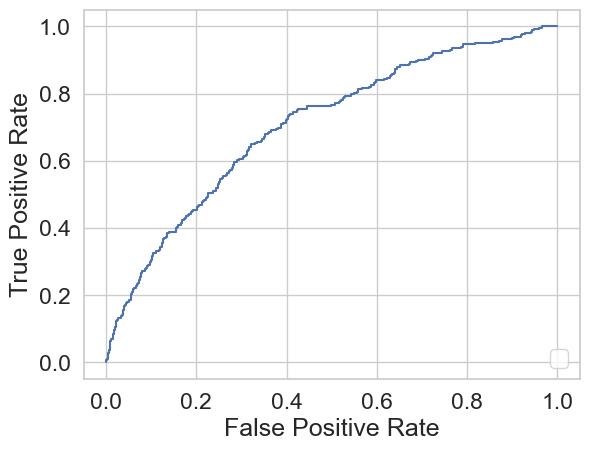

In [150]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, pipe.predict_proba(X_test)[:, 1])

from sklearn.metrics import RocCurveDisplay

RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

In [151]:
from sklearn.metrics import auc

auc(fpr, tpr)

0.7063163087074654

In [152]:
from sklearn.metrics import classification_report


print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.97      0.69      0.81      4720
           1       0.10      0.61      0.17       262

    accuracy                           0.69      4982
   macro avg       0.53      0.65      0.49      4982
weighted avg       0.92      0.69      0.77      4982



## Эксперимент №2 Бустинг

In [169]:
# Катбуст из финального проекта K/C

from catboost import CatBoostClassifier
# Initialize CatBoostClassifier
catboost_model = CatBoostClassifier(
    iterations=100,  # Modify this parameter as needed
    thread_count=8, 
    custom_metric = ['F1', 'Precision', 'Recall', 'Accuracy'],
    eval_metric='AUC',  # Changed to AUC
    auto_class_weights='Balanced' ,
    verbose=50,  # Output the training process every 100 iterations
    random_seed=42
    
)

# Fit model
catboost_model.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True)

Learning rate set to 0.180666
0:	test: 0.6712030	best: 0.6712030 (0)	total: 14.2ms	remaining: 1.41s
50:	test: 0.7066867	best: 0.7096592 (38)	total: 624ms	remaining: 600ms
99:	test: 0.6970428	best: 0.7142256 (65)	total: 1.22s	remaining: 0us

bestTest = 0.7142256437
bestIteration = 65

Shrink model to first 66 iterations.


In [163]:
catboost_model.get_best_score()

{'learn': {'Accuracy:use_weights=false': 0.8808209554395825,
  'Precision:use_weights=false': 0.3046690307328605,
  'Recall:use_weights=false': 0.9791073124406457,
  'Accuracy:use_weights=true': 0.9272225305235843,
  'Logloss': 0.3125444220197296,
  'Precision:use_weights=true': 0.8870577200604635,
  'Recall:use_weights=true': 0.9791073124406457,
  'F1:use_weights=true': 0.930812318462634,
  'F1:use_weights=false': 0.4647284201036736},
 'validation': {'Accuracy:use_weights=false': 0.8259735046166198,
  'Recall:use_weights=false': 0.6641221374045801,
  'Precision:use_weights=false': 0.13064713064713065,
  'Accuracy:use_weights=true': 0.6641029465098623,
  'AUC': 0.7142256436796481,
  'Logloss': 0.6255364769905212,
  'Precision:use_weights=true': 0.7292747326053072,
  'Recall:use_weights=true': 0.6641221374045801,
  'F1:use_weights=true': 0.6547169980500215,
  'F1:use_weights=false': 0.20186113099498929}}

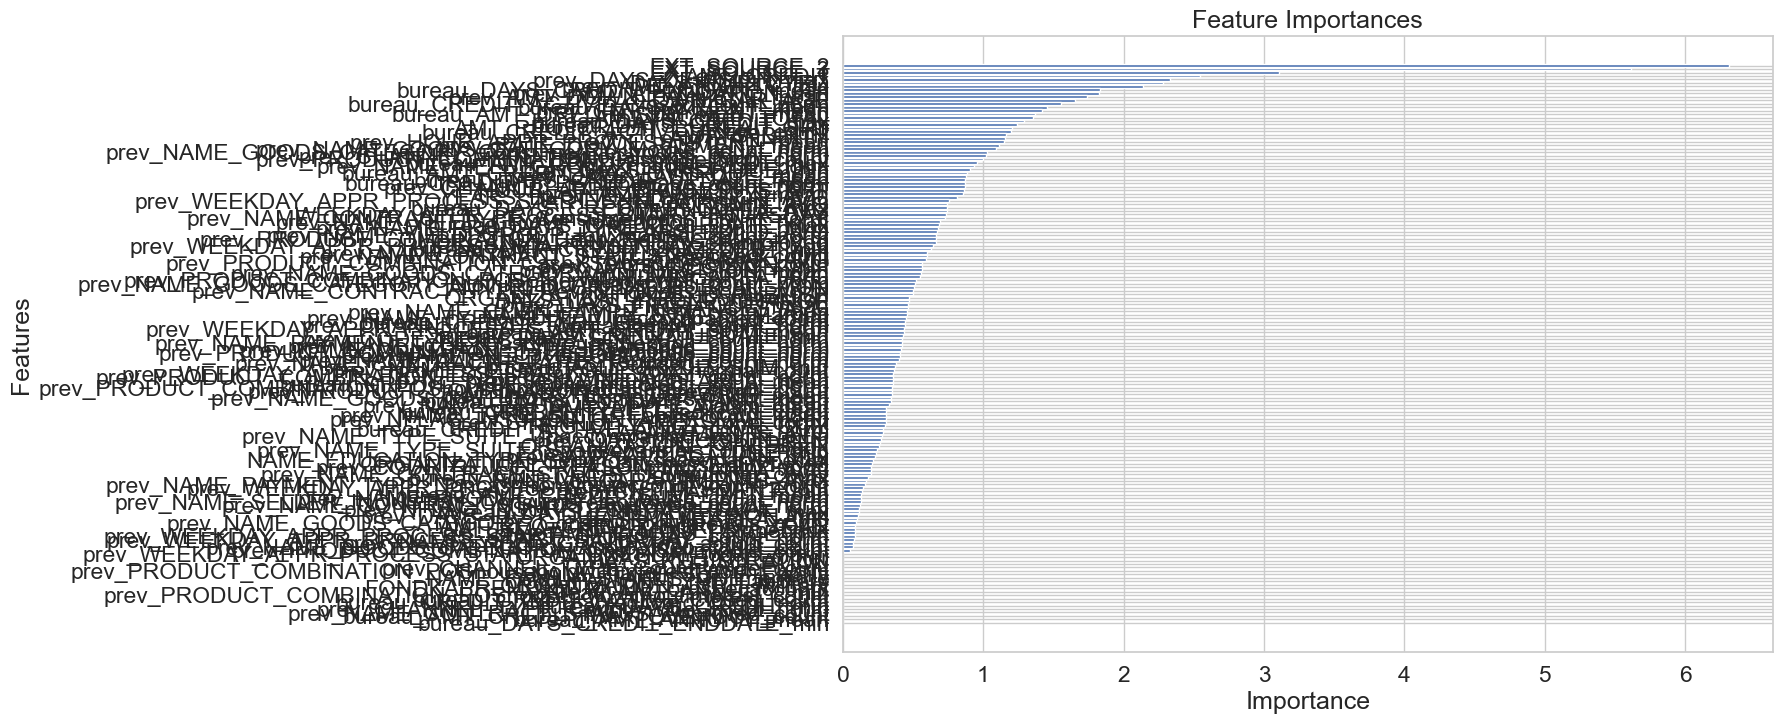

In [170]:
import matplotlib.pyplot as plt

# Get feature importances
feature_importances = catboost_model.get_feature_importance()

# Create a pandas dataframe for easier visualization
importance_df = pd.DataFrame({
    'Features': X_train.columns,
    'Importance': feature_importances
})

# Sort the dataframe based on the feature importances
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 8))
plt.barh(importance_df['Features'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importances')
plt.gca().invert_yaxis()
plt.show()

In [165]:
# Всё ещё огромное количество фич требует удаления из датасета
importance_df[importance_df["Importance"] <= 0.5]

,Features,Importance
78,prev_NAME_CONTRACT_TYPE_Revolvingloans_count_norm,0.499137
7,DAYS_ID_PUBLISH,0.496856
38,ORGANIZATION_TYPE_Construction,0.469036
26,DAYS_LAST_PHONE_CHANGE,0.468238
155,prev_DAYS_FIRST_DUE_mean,0.466309
...,...,...
116,prev_CHANNEL_TYPE_Countrywide_count_norm,0.000000
87,prev_NAME_CONTRACT_STATUS_Approved_count,0.000000
62,bureau_AMT_CREDIT_MAX_OVERDUE_count,0.000000
74,bureau_AMT_ANNUITY_mean,0.000000


### Эксперимент 2.5 Нетюненный катбуст с удалёнными низкоприоритетными фичами
#### Спойлер! Была обнаружена сходимость удаления фичей при близком качестве. Этот эксперимент я планирую выбрать как бэйзлайн модели.

In [193]:
# Посчитать gini для этого эксперимента и precision at 1 (done)

In [194]:
# Initialize CatBoostClassifier
catboost_model = CatBoostClassifier(
    iterations=100,  # Modify this parameter as needed
    thread_count=8, 
    custom_metric = ['F1:use_weights=true', 
                     'Precision:use_weights=true', 
                     'Recall:use_weights=true', 
                     'Accuracy:use_weights=true', 
                     'NormalizedGini:use_weights=true'],
    eval_metric='AUC',  # Changed to AUC
    auto_class_weights='Balanced' ,
    verbose=100,  # Output the training process every 100 iterations
    random_seed=42
    
)

In [179]:

# Create a pandas dataframe for easier visualization
def create_importance_df(X_train, feature_importances):
    importance_df = pd.DataFrame({
        'Features': X_train.columns,
        'Importance': feature_importances
    })
    
    # Sort the dataframe based on the feature importances
    importance_df = importance_df.sort_values(by='Importance', ascending=False)
    return importance_df

In [180]:
# Get feature importances
def get_feature_importances():
    feature_importances = catboost_model.get_feature_importance()
    importance_df = importance_df_dr

    # Plot the feature importances
    plt.figure(figsize=(12, 8))
    plt.barh(importance_df['Features'], importance_df['Importance'])
    plt.xlabel('Importance')
    plt.ylabel('Features')
    plt.title('Feature Importances')
    plt.gca().invert_yaxis()
    plt.show()

Learning rate set to 0.180666
0:	test: 0.6622004	best: 0.6622004 (0)	total: 9.65ms	remaining: 956ms
99:	test: 0.6856337	best: 0.7179470 (15)	total: 832ms	remaining: 0us

bestTest = 0.7179470177
bestIteration = 15

Shrink model to first 16 iterations.
Learning rate set to 0.180666
0:	test: 0.6570037	best: 0.6570037 (0)	total: 8.27ms	remaining: 818ms
99:	test: 0.6768938	best: 0.6954886 (20)	total: 633ms	remaining: 0us

bestTest = 0.695488582
bestIteration = 20

Shrink model to first 21 iterations.
Learning rate set to 0.180666
0:	test: 0.6497340	best: 0.6497340 (0)	total: 20.2ms	remaining: 2s
99:	test: 0.7061433	best: 0.7206163 (19)	total: 644ms	remaining: 0us

bestTest = 0.7206163475
bestIteration = 19

Shrink model to first 20 iterations.
Learning rate set to 0.180666
0:	test: 0.6580941	best: 0.6580941 (0)	total: 19ms	remaining: 1.88s
99:	test: 0.7024777	best: 0.7123027 (59)	total: 622ms	remaining: 0us

bestTest = 0.7123026912
bestIteration = 59

Shrink model to first 60 iterations.


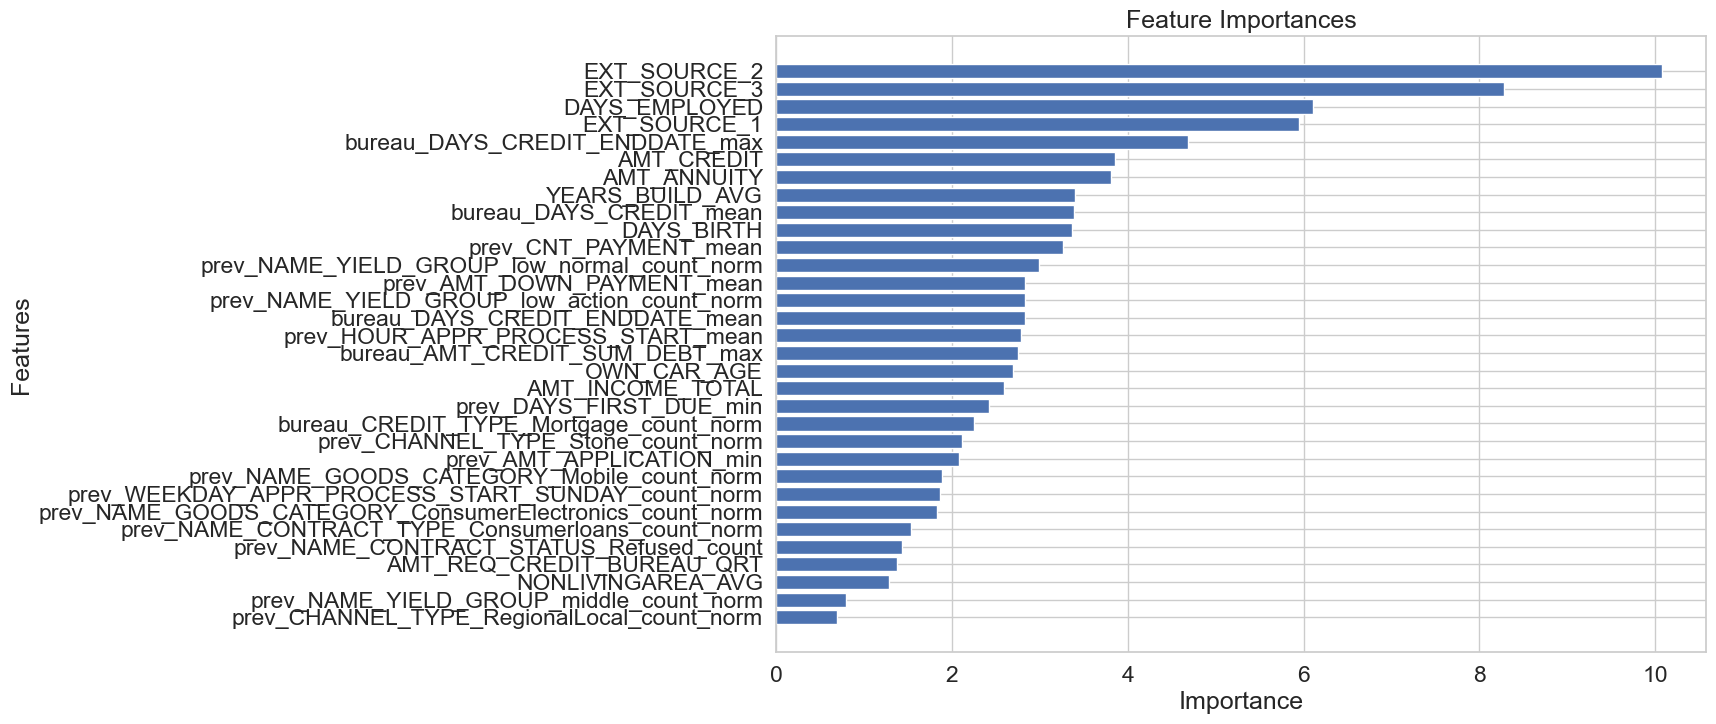

{'learn': {'Accuracy:use_weights=true': 0.899219234999046,
  'Logloss': 0.34176071093289156,
  'Precision:use_weights=true': 0.8589156063442569,
  'F1:use_weights=true': 0.904576897664968,
  'Recall:use_weights=true': 0.9553656220322887},
 'validation': {'NormalizedGini:use_weights=true': 0.4246053823263036,
  'Accuracy:use_weights=true': 0.6619842244935759,
  'Logloss': 0.625045340853494,
  'Precision:use_weights=true': 0.7098280148514574,
  'F1:use_weights=true': 0.6571967992155273,
  'Recall:use_weights=true': 0.7251908396946565,
  'AUC': 0.7123026911631518}}

In [195]:
importance_df_dr = importance_df
features_to_drop = importance_df_dr[importance_df_dr["Importance"] <= 0.5]["Features"]
train_dropped = train.drop(columns=features_to_drop)

while len(importance_df_dr[importance_df_dr["Importance"] <= 0.5]) > 0:
   
    X_dr = train_dropped.drop(columns=["TARGET"]).set_index("SK_ID_CURR")
    y_dr = train_dropped["TARGET"]
    
    X_train_dr, X_test_dr, y_train_dr, y_test_dr = train_test_split(X_dr, y_dr, 
                                                        random_state=42, 
                                                        test_size=0.2)
    
    # Fit model
    catboost_model.fit(X_train_dr, y_train_dr, eval_set=(X_test_dr, y_test_dr), use_best_model=True)
    feature_importances_dr = catboost_model.get_feature_importance()
    importance_df_dr = create_importance_df(X_train_dr, feature_importances_dr)
    features_to_drop = importance_df_dr[importance_df_dr["Importance"] <= 0.5]["Features"]
    train_dropped = train_dropped.drop(columns=features_to_drop)
get_feature_importances()
catboost_model.get_best_score()

In [196]:
# Пытаемся понять значение 'Precision:use_weights=true': 0.7098280148514574
print(classification_report(y_test, catboost_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.97      0.76      0.85      4720
           1       0.11      0.54      0.18       262

    accuracy                           0.75      4982
   macro avg       0.54      0.65      0.52      4982
weighted avg       0.92      0.75      0.82      4982



In [197]:
importance_df_dr

,Features,Importance
7,EXT_SOURCE_2,10.077752
8,EXT_SOURCE_3,8.277745
4,DAYS_EMPLOYED,6.104885
6,EXT_SOURCE_1,5.947520
15,bureau_DAYS_CREDIT_ENDDATE_max,4.679756
1,AMT_CREDIT,3.850627
2,AMT_ANNUITY,3.806385
9,YEARS_BUILD_AVG,3.402792
13,bureau_DAYS_CREDIT_mean,3.391960
3,DAYS_BIRTH,3.366466


## Эксперимент №3 AutoML

In [101]:
N_THREADS = 4
N_FOLDS = 5
RANDOM_STATE = 42
TEST_SIZE = 0.2
TIMEOUT = 300
TARGET_NAME = 'TARGET'


task = Task('binary')
roles = {
    'target': TARGET_NAME,
    'drop': ['SK_ID_CURR']
}


In [102]:
np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

In [104]:
train_data, test_data = train_test_split(
    train,
    test_size=TEST_SIZE,
    stratify=train[TARGET_NAME],
    random_state=RANDOM_STATE
)

In [105]:
RD = ReportDeco(output_path = 'tabularAutoML_model_report')

automl_rd = RD(
    TabularAutoML(
        task = task,
        timeout = TIMEOUT,
        cpu_limit = N_THREADS,
        reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE}
    )
)



In [106]:
%%time
out_of_fold_predictions = automl_rd.fit_predict(train_data, roles = roles, verbose = 1)

[22:17:27] Stdout logging level is INFO.
[22:17:27] Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer
[22:17:27] Task: binary

[22:17:27] Start automl preset with listed constraints:
[22:17:27] - time: 300.00 seconds
[22:17:27] - CPU: 4 cores
[22:17:27] - memory: 16 GB

[22:17:27] Train data shape: (19928, 164)

[22:17:36] Layer 1 train process start. Time left 290.69 secs
[22:17:37] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[22:17:41] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.7453983753888697
[22:17:41] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[22:17:41] Time left 285.96 secs

[22:17:47] Selector_LightGBM fitting and predicting completed
[22:17:48] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[22:18:08] Time limit exceeded after calculating fold 3

[22:18:08] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.7379092416682541
[22:18:08] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting comple